
Here we walk through version 1.6 of the DADA2 pipeline on a small multi-sample dataset. Our starting point is a set of Illumina-sequenced paired-end fastq files that have been split (or "demultiplexed") by sample and from which the barcodes/adapters have already been removed. The end product is an **amplicon sequence variant (ASV) table**, a higher-resolution analogue of the traditional "OTU table", which records the number of times each amplicon sequence variant was observed in each sample. We also assign taxonomy to the output sequences, and demonstrate how the data can be imported into the popular [phyloseq](https://joey711.github.io/phyloseq/) R package for the analysis of microbiome data.

-----------------------

# Starting point

This workflow assumes that your sequencing data meets certain criteria:

* Samples have been demultiplexed, i.e. split into individual per-sample fastq files.
* Non-biological nucleotides have been removed, e.g. primers, adapters, linkers, etc.
* If paired-end sequencing data, the forward and reverse fastq files contain reads in matched order.

If these criteria are not true for your data (**are you sure there aren't any primers hanging around?**) you need to remedy those issues before beginning this workflow. See [the FAQ](faq.html) for some recommendations for common issues.

# Getting ready

First we load the `dada2` package If you don't already it, see the [dada2 installation instructions](dada-installation.html):


In [1]:
library(dada2); packageVersion("dada2")
library(readr)

library(phyloseq); packageVersion("phyloseq")
library(ggplot2); packageVersion("ggplot2")
theme_set(theme_bw())

Loading required package: Rcpp
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


[1] ‘1.12.1’

[1] ‘1.28.0’

[1] ‘3.1.1’

*Older versions of this workflow associated with previous release versions or the dada2 R package are also available: [version 1.2](tutorial_1_2.html), [version 1.4](tutorial_1_4.html).*

The data we will work with are the same as those used in the [Mothur Miseq SOP](http://www.mothur.org/wiki/MiSeq_SOP). Download the [example data](http://www.mothur.org/w/images/d/d6/MiSeqSOPData.zip) and unzip. These fastq files were generated by amplicon sequencing (Illumina MiSeq, 2x250, V4 region of the 16S rRNA gene) of gut samples collected longitudinally from a mouse post-weaning, and one mock community control. For now just consider them paired-end fastq files to be processed. Define the following path variable so that it points to the extracted directory on **your** machine:

## Set Paths
We need to set up a "scratch" directory for saving files that we generate while running dada2, but don't need to save long term.

In [2]:
scratch.dir = path.expand("~/work/scratch/miseq_sop")
dir.create(scratch.dir, recursive = TRUE)

miseqsop.dir = file.path(scratch.dir,"MiSeq_SOP")

silva.url = "https://zenodo.org/record/1172783/files/silva_nr_v132_train_set.fa.gz"
silva.ref = file.path(scratch.dir, basename(silva.url))
# silva.species.ref = "/data/references/dada/silva_species_assignment_v128.fa.gz"

ps.rds = file.path(scratch.dir, "miseq_sop.rds")

Warning message in dir.create(scratch.dir, recursive = TRUE):
“'/home/jovyan/work/scratch/miseq_sop' already exists”

## Download Data

In [3]:
miseq_sop_url = "http://www.mothur.org/w/images/d/d6/MiSeqSOPData.zip"
miseq_sop_data_zip = file.path(scratch.dir,basename(miseq_sop_url))
download.file(miseq_sop_url, destfile = miseq_sop_data_zip)

In [4]:
download.file(miseq_sop_url, destfile = miseq_sop_data_zip)

In [5]:
download.file(silva.url, destfile = silva.ref)

In [6]:
list.files(scratch.dir)
unzip(miseq_sop_data_zip, exdir=scratch.dir)
list.files(miseqsop.dir)
unlink(miseq_sop_data_zip)

[1] "__MACOSX"                      "filtered"                     
[3] "MiSeq_SOP"                     "MiSeqSOPData.zip"             
[5] "silva_nr_v132_train_set.fa.gz"

[1] "F3D0_S188_L001_R1_001.fastq"   "F3D0_S188_L001_R2_001.fastq"  
 [3] "F3D1_S189_L001_R1_001.fastq"   "F3D1_S189_L001_R2_001.fastq"  
 [5] "F3D141_S207_L001_R1_001.fastq" "F3D141_S207_L001_R2_001.fastq"
 [7] "F3D142_S208_L001_R1_001.fastq" "F3D142_S208_L001_R2_001.fastq"
 [9] "F3D143_S209_L001_R1_001.fastq" "F3D143_S209_L001_R2_001.fastq"
[11] "F3D144_S210_L001_R1_001.fastq" "F3D144_S210_L001_R2_001.fastq"
[13] "F3D145_S211_L001_R1_001.fastq" "F3D145_S211_L001_R2_001.fastq"
[15] "F3D146_S212_L001_R1_001.fastq" "F3D146_S212_L001_R2_001.fastq"
[17] "F3D147_S213_L001_R1_001.fastq" "F3D147_S213_L001_R2_001.fastq"
[19] "F3D148_S214_L001_R1_001.fastq" "F3D148_S214_L001_R2_001.fastq"
[21] "F3D149_S215_L001_R1_001.fastq" "F3D149_S215_L001_R2_001.fastq"
[23] "F3D150_S216_L001_R1_001.fastq" "F3D150_S216_L001_R2_001.fastq"
[25] "F3D2_S190_L001_R1_001.fastq"   "F3D2_S190_L001_R2_001.fastq"  
[27] "F3D3_S191_L001_R1_001.fastq"   "F3D3_S191_L001_R2_001.fastq"  
[29] "F3D5_S193_L001_R1_001.fastq"   "F3D5_S193_L001_R2_001.fastq"  
[31] "F3D6_S194_L001_R1_001.fastq"   "F3D6_S194_L001_R2_001.fastq"  
[33] "F3D7_S195_L001_R1_001.fastq"   "F3D7_S195_L001_R2_001.fastq"  
[35] "F3D8_S196_L001_R1_001.fastq"   "F3D8_S196_L001_R2_001.fastq"  
[37] "F3D9_S197_L001_R1_001.fastq"   "F3D9_S197_L001_R2_001.fastq"  
[39] "HMP_MOCK.v35.fasta"            "Mock_S280_L001_R1_001.fastq"  
[41] "Mock_S280_L001_R2_001.fastq"   "mouse.dpw.metadata"           
[43] "mouse.time.design"             "stability.batch"              
[45] "stability.files"

In [7]:
list.files(scratch.dir)

[1] "__MACOSX"                      "filtered"                     
[3] "MiSeq_SOP"                     "silva_nr_v132_train_set.fa.gz"

# Filter and Trim

First we read in the names of the fastq files, and perform some string manipulation to get lists of the forward and reverse fastq files in matched order:

In [8]:
# Forward and reverse fastq filenames have format: SAMPLENAME_R1_001.fastq and SAMPLENAME_R2_001.fastq
fnFs <- sort(list.files(miseqsop.dir, pattern="_R1_001.fastq", full.names = TRUE))
fnRs <- sort(list.files(miseqsop.dir, pattern="_R2_001.fastq", full.names = TRUE))
# Extract sample names, assuming filenames have format: SAMPLENAME_XXX.fastq
sample.names <- sapply(strsplit(basename(fnFs), "_"), `[`, 1)

## Examine quality profiles of forward and reverse reads

We start by visualizing the quality profiles of the forward reads:

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


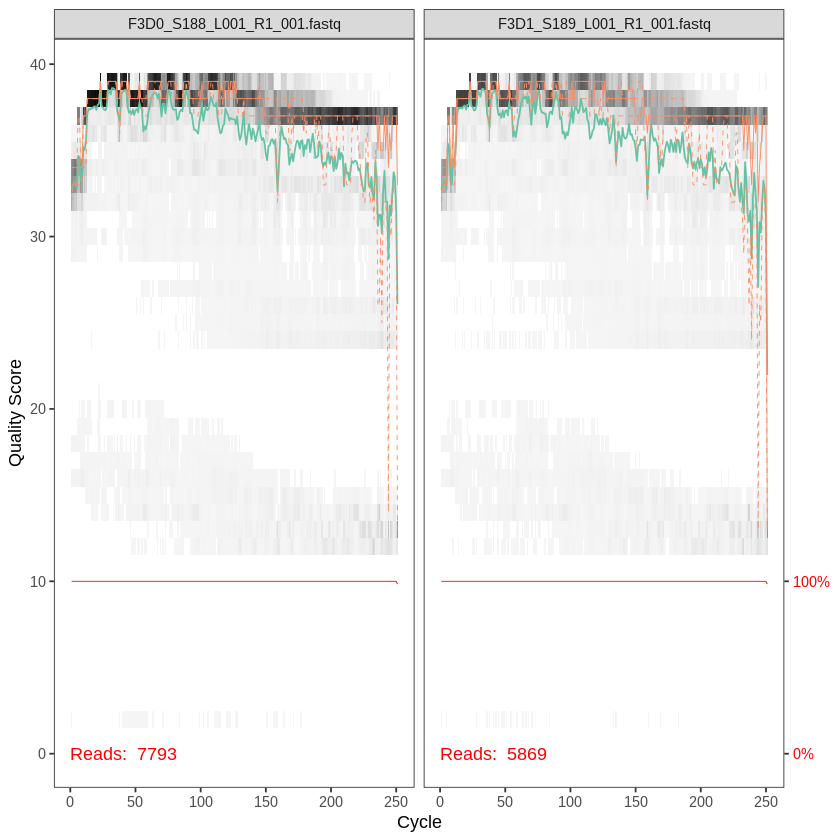

In [9]:
plotQualityProfile(fnFs[1:2])

The forward reads are good quality. We generally advise trimming the last few nucleotides to avoid less well-controlled errors that can arise there. These quality profiles do not suggest that any additional trimming is needed, so we will truncate the forward reads at position 240 (trimming the last 10 nucleotides).

Now we visualize the quality profile of the reverse reads:

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


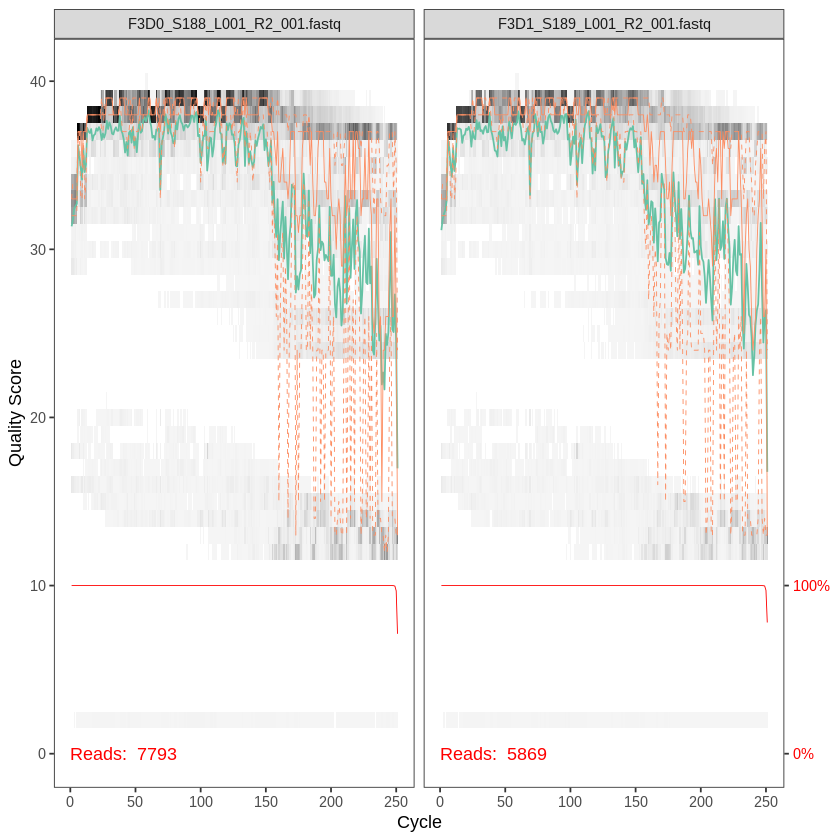

In [10]:
plotQualityProfile(fnRs[1:2])

The reverse reads are of significantly worse quality, especially at the end, which is common in Illumina sequencing. This isn't too worrisome, as DADA2 incorporates quality information into its error model which makes the algorithm [robust to lower quality sequence](https://twitter.com/bejcal/status/771010634074820608), but trimming as the average qualities crash will improve the algorithm's sensitivity to rare sequence variants. Based on these profiles, we will truncate the reverse reads at position 160 where the quality distribution crashes.


## Perform filtering and trimming

Assign the filenames for the filtered fastq.gz files.

In [11]:
filt_path <- file.path(scratch.dir, "filtered") # Place filtered files in filtered/ subdirectory
filtFs <- file.path(filt_path, paste0(sample.names, "_F_filt.fastq.gz"))
filtRs <- file.path(filt_path, paste0(sample.names, "_R_filt.fastq.gz"))

We'll use standard filtering parameters: `maxN=0` (DADA2 requires no Ns), `truncQ=2`, `rm.phix=TRUE` and `maxEE=2`. The `maxEE` parameter sets the maximum number of "expected errors" allowed in a read, which is [a better filter than simply averaging quality scores](http://www.drive5.com/usearch/manual/expected_errors.html).

**Filter the forward and reverse reads**

In [12]:
out <- filterAndTrim(fnFs, filtFs, fnRs, filtRs, trimLeft=10, truncLen=c(240,160),
              maxN=0, maxEE=c(2,2), truncQ=2, rm.phix=TRUE,
              compress=TRUE, multithread=FALSE) # On Windows set multithread=FALSE
head(out)

,reads.in,reads.out
F3D0_S188_L001_R1_001.fastq,7793,7139
F3D1_S189_L001_R1_001.fastq,5869,5314
F3D141_S207_L001_R1_001.fastq,5958,5478
F3D142_S208_L001_R1_001.fastq,3183,2926
F3D143_S209_L001_R1_001.fastq,3178,2955
F3D144_S210_L001_R1_001.fastq,4827,4323


# Learn the Error Rates

The DADA2 algorithm depends on a parametric error model (`err`) and every amplicon dataset has a different set of error rates. The `learnErrors` method learns the error model from the data, by alternating estimation of the error rates and inference of sample composition until they converge on a jointly consistent solution. As in many optimization problems, the algorithm must begin with an initial guess, for which the maximum possible error rates in this data are used (the error rates if only the most abundant sequence is correct and all the rest are errors).

In [13]:
errF <- learnErrors(filtFs, multithread=TRUE)
errR <- learnErrors(filtRs, multithread=TRUE)

32228750 total bases in 140125 reads from 20 samples will be used for learning the error rates.
21018750 total bases in 140125 reads from 20 samples will be used for learning the error rates.


It is always worthwhile, as a sanity check if nothing else, to visualize the estimated error rates:

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”

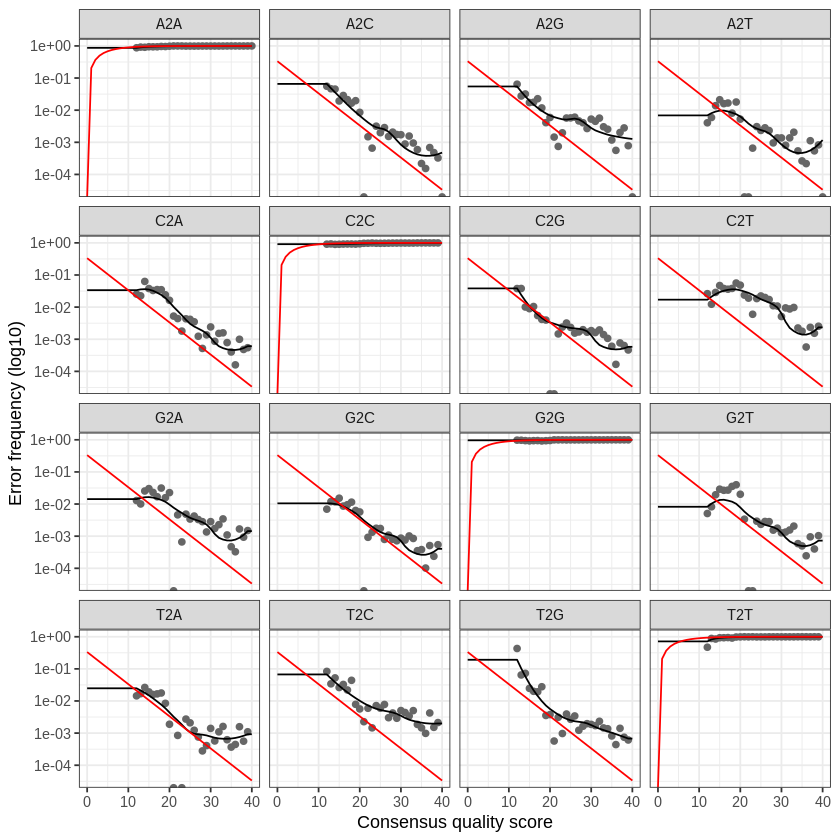

In [14]:
plotErrors(errF, nominalQ=TRUE)

The error rates for each possible transition (eg. A->C, A->G, ...) are shown. Points are the observed error rates for each consensus quality score. The black line shows the estimated error rates after convergence. The red line shows the error rates expected under the nominal definition of the Q-value. Here the black line (the estimated rates) fits the observed rates well, and the error rates drop with increased quality as expected. Everything looks reasonable and we proceed with confidence.


# Dereplication

Dereplication combines all identical sequencing reads into into "unique sequences" with a corresponding "abundance": the number of reads with that unique sequence. Dereplication substantially reduces computation time by eliminating redundant comparisons.

Dereplication in the DADA2 pipeline has one crucial addition from other pipelines: **DADA2 retains a summary of the quality information associated with each unique sequence**. The consensus quality profile of a unique sequence is the average of the positional qualities from the dereplicated reads. These quality profiles inform the error model of the subsequent denoising step, significantly increasing DADA2's accuracy.

**Dereplicate the filtered fastq files**

In [15]:
derepFs <- derepFastq(filtFs, verbose=TRUE)
derepRs <- derepFastq(filtRs, verbose=TRUE)
# Name the derep-class objects by the sample names
names(derepFs) <- sample.names
names(derepRs) <- sample.names

Dereplicating sequence entries in Fastq file: /home/jovyan/work/scratch/miseq_sop/filtered/F3D0_F_filt.fastq.gz
Encountered 1866 unique sequences from 7139 total sequences read.
Dereplicating sequence entries in Fastq file: /home/jovyan/work/scratch/miseq_sop/filtered/F3D1_F_filt.fastq.gz
Encountered 1543 unique sequences from 5314 total sequences read.
Dereplicating sequence entries in Fastq file: /home/jovyan/work/scratch/miseq_sop/filtered/F3D141_F_filt.fastq.gz
Encountered 1415 unique sequences from 5478 total sequences read.
Dereplicating sequence entries in Fastq file: /home/jovyan/work/scratch/miseq_sop/filtered/F3D142_F_filt.fastq.gz
Encountered 870 unique sequences from 2926 total sequences read.
Dereplicating sequence entries in Fastq file: /home/jovyan/work/scratch/miseq_sop/filtered/F3D143_F_filt.fastq.gz
Encountered 901 unique sequences from 2955 total sequences read.
Dereplicating sequence entries in Fastq file: /home/jovyan/work/scratch/miseq_sop/filtered/F3D144_F_filt.f

# Sample Inference

We are now ready to apply the core sequence-variant inference algorithm to the dereplicated data. 

**Infer the sequence variants in each sample**

In [16]:
dadaFs <- dada(derepFs, err=errF, multithread=TRUE)
dadaRs <- dada(derepRs, err=errR, multithread=TRUE)

Sample 1 - 7139 reads in 1866 unique sequences.
Sample 2 - 5314 reads in 1543 unique sequences.
Sample 3 - 5478 reads in 1415 unique sequences.
Sample 4 - 2926 reads in 870 unique sequences.
Sample 5 - 2955 reads in 901 unique sequences.
Sample 6 - 4323 reads in 1227 unique sequences.
Sample 7 - 6762 reads in 1690 unique sequences.
Sample 8 - 4580 reads in 1373 unique sequences.
Sample 9 - 15695 reads in 3423 unique sequences.
Sample 10 - 11448 reads in 2629 unique sequences.
Sample 11 - 12064 reads in 2905 unique sequences.
Sample 12 - 5054 reads in 1503 unique sequences.
Sample 13 - 18130 reads in 3493 unique sequences.
Sample 14 - 6275 reads in 1410 unique sequences.
Sample 15 - 4068 reads in 1148 unique sequences.
Sample 16 - 7394 reads in 1760 unique sequences.
Sample 17 - 4772 reads in 1127 unique sequences.
Sample 18 - 4890 reads in 1302 unique sequences.
Sample 19 - 6525 reads in 1613 unique sequences.
Sample 20 - 4333 reads in 845 unique sequences.
Sample 1 - 7139 reads in 156

Inspecting the dada-class object returned by dada:

In [17]:
dadaFs[[1]]

sequence,abundance,n0,n1,nunq,pval,birth_type,birth_pval,birth_fold,birth_ham,birth_qave
<chr>,<int>,<int>,<int>,<int>,<dbl>,<fct>,<dbl>,<dbl>,<int>,<dbl>
GCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGCAGGCGGAAGATCAAGTCAGCGGTAAAATTGAGAGGCTCAACCTCTTCGAGCCGTTGAAACTGGTTTTCTTGAGTGAGCGAGAAGTATGCGGAATGCGTGGTGTAGCGGTGAAATGCATAGATATCACGCAGAACTCCGATTGCGAAGGCAGCATACCGGCGCTCAACTGACGCTCATGCACGAAAGTGTGG,590,469,73,89,0,I,NA,NA,NA,NA
GCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGCCTGCCAAGTCAGCGGTAAAATTGCGGGGCTCAACCCCGTACAGCCGTTGAAACTGCCGGGCTCGAGTGGGCGAGAAGTATGCGGAATGCGTGGTGTAGCGGTGAAATGCATAGATATCACGCAGAACCCCGATTGCGAAGGCAGCATACCGGCGCCCTACTGACGCTGAGGCACGAAAGTGCGG,499,392,62,93,0,A,0,7.820891e+74,25,37.08000
GCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGGCTGTTAAGTCAGCGGTCAAATGTCGGGGCTCAACCCCGGCCTGCCGTTGAAACTGGCGGCCTCGAGTGGGCGAGAAGTATGCGGAATGCGTGGTGTAGCGGTGAAATGCATAGATATCACGCAGAACTCCGATTGCGAAGGCAGCATACCGGCGCCCGACTGACGCTGAGGCACGAAAGCGTGG,456,362,60,76,0,A,0,3.050128e+45,15,36.86667
GCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGGCTTTTAAGTCAGCGGTAAAAATTCGGGGCTCAACCCCGTCCGGCCGTTGAAACTGGGGGCCTTGAGTGGGCGAGAAGAAGGCGGAATGCGTGGTGTAGCGGTGAAATGCATAGATATCACGCAGAACCCCGATTGCGAAGGCAGCCTTCCGGCGCCCTACTGACGCTGAGGCACGAAAGTGCGG,448,344,62,84,0,A,0,1.370680e+48,16,36.50000
GCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGCAGGCGGACTCTCAAGTCAGCGGTCAAATCGCGGGGCTCAACCCCGTTCCGCCGTTGAAACTGGGAGCCTTGAGTGCGCGAGAAGTAGGCGGAATGCGTGGTGTAGCGGTGAAATGCATAGATATCACGCAGAACTCCGATTGCGAAGGCAGCCTACCGGCGCGCAACTGACGCTCATGCACGAAAGCGTGG,348,284,35,59,0,A,0,1.830229e+55,18,37.44444
GCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGGATGCCAAGTCAGCGGTAAAAAAGCGGTGCTCAACGCCGTCGAGCCGTTGAAACTGGCGTTCTTGAGTGGGCGAGAAGTATGCGGAATGCGTGGTGTAGCGGTGAAATGCATAGATATCACGCAGAACTCCGATTGCGAAGGCAGCATACCGGCGCCCTACTGACGCTGAGGCACGAAAGCGTGG,289,219,40,62,0,A,0,2.086846e+46,15,36.73333
GCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGCCTGCCAAGTCAGCGGTAAAATTGCGGGGCTCAACCCCGTACAGCCGTTGAAACTGCCGGGCTCGAGTGGGCGAGAAGTATGCGGAATGCGTGGTGTAGCGGTGAAATGCATAGATATCACGCAGAACCCCGATTGCGAAGGCAGCATACCGGCGCCCGACTGACGCTGAGGCACGAAAGTGCGG,230,172,38,44,0,A,0,4.058839e+02,1,35.00000
TCAAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGTTCGATAAGTTAGAGGTGAAATCCCGGGGCTCAACTCCGGCACTGCCTCTGATACTGTCGGGCTAGAGTTTAGTTGCGGTAGGCGGAATGTATGGTGTAGCGGTGAAATGCATAGAGATCATACAGAACACCGATTGCGAAGGCAGCTTACCAAACTACGACTGACGTTGAGGCACGAAAGCGTG,185,142,19,40,0,A,0,6.114434e+144,48,36.83333
CCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGTGGATTGTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGAAACTGGCAGTCTTGAGTACAGTAGAGGTGGGCGGAATTCGTGGTGTAGCGGTGAAATGCTTAGATATCACGAAGAACTCCGATTGCGAAGGCAGCTCACTGGACTGCAACTGACACTGATGCTCGAAAGTGTG,174,128,31,27,0,A,0,3.543873e+120,40,37.90000


In [18]:
cat("blah", length(dadaFs[[1]]$sequence))

blah 130

In [19]:
cat("The DADA2 algorithm inferred", 
    length(dadaFs[[1]]$sequence), 
    "real sequence variants from the", 
    length(dadaFs[[1]]$map),
    "unique sequences in the first sample")

The DADA2 algorithm inferred 130 real sequence variants from the 1866 unique sequences in the first sample

There is much more to the `dada-class` return object than this (see `help("dada-class")` for some info), including multiple diagnostics about the quality of each inferred sequence variant, but that is beyond the scope of an introductory tutorial.

# Merge paired reads

Spurious sequence variants are further reduced by merging overlapping reads. The core function here is `mergePairs`, which depends on the forward and reverse reads being in matching order at the time they were dereplicated.

**Merge the denoised forward and reverse reads**:

In [20]:
mergers <- mergePairs(dadaFs, derepFs, dadaRs, derepRs, verbose=TRUE)
# Inspect the merger data.frame from the first sample
head(mergers[[1]])

6667 paired-reads (in 110 unique pairings) successfully merged out of 6954 (in 190 pairings) input.
5028 paired-reads (in 101 unique pairings) successfully merged out of 5211 (in 163 pairings) input.
4995 paired-reads (in 80 unique pairings) successfully merged out of 5297 (in 172 pairings) input.
2611 paired-reads (in 51 unique pairings) successfully merged out of 2777 (in 111 pairings) input.
2598 paired-reads (in 63 unique pairings) successfully merged out of 2804 (in 115 pairings) input.
3690 paired-reads (in 56 unique pairings) successfully merged out of 4117 (in 145 pairings) input.
6150 paired-reads (in 84 unique pairings) successfully merged out of 6557 (in 198 pairings) input.
4003 paired-reads (in 92 unique pairings) successfully merged out of 4387 (in 192 pairings) input.
14080 paired-reads (in 140 unique pairings) successfully merged out of 15412 (in 344 pairings) input.
10567 paired-reads (in 119 unique pairings) successfully merged out of 11193 (in 263 pairings) input.
11

sequence,abundance,forward,reverse,nmatch,nmismatch,nindel,prefer,accept
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<lgl>
GCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGCAGGCGGAAGATCAAGTCAGCGGTAAAATTGAGAGGCTCAACCTCTTCGAGCCGTTGAAACTGGTTTTCTTGAGTGAGCGAGAAGTATGCGGAATGCGTGGTGTAGCGGTGAAATGCATAGATATCACGCAGAACTCCGATTGCGAAGGCAGCATACCGGCGCTCAACTGACGCTCATGCACGAAAGTGTGGGT,582,1,1,148,0,0,1,TRUE
GCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGCCTGCCAAGTCAGCGGTAAAATTGCGGGGCTCAACCCCGTACAGCCGTTGAAACTGCCGGGCTCGAGTGGGCGAGAAGTATGCGGAATGCGTGGTGTAGCGGTGAAATGCATAGATATCACGCAGAACCCCGATTGCGAAGGCAGCATACCGGCGCCCTACTGACGCTGAGGCACGAAAGTGCGGGG,495,2,2,148,0,0,1,TRUE
GCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGGCTGTTAAGTCAGCGGTCAAATGTCGGGGCTCAACCCCGGCCTGCCGTTGAAACTGGCGGCCTCGAGTGGGCGAGAAGTATGCGGAATGCGTGGTGTAGCGGTGAAATGCATAGATATCACGCAGAACTCCGATTGCGAAGGCAGCATACCGGCGCCCGACTGACGCTGAGGCACGAAAGCGTGGGT,451,3,4,148,0,0,1,TRUE
GCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGGCTTTTAAGTCAGCGGTAAAAATTCGGGGCTCAACCCCGTCCGGCCGTTGAAACTGGGGGCCTTGAGTGGGCGAGAAGAAGGCGGAATGCGTGGTGTAGCGGTGAAATGCATAGATATCACGCAGAACCCCGATTGCGAAGGCAGCCTTCCGGCGCCCTACTGACGCTGAGGCACGAAAGTGCGGGG,442,4,3,148,0,0,2,TRUE
GCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGCAGGCGGACTCTCAAGTCAGCGGTCAAATCGCGGGGCTCAACCCCGTTCCGCCGTTGAAACTGGGAGCCTTGAGTGCGCGAGAAGTAGGCGGAATGCGTGGTGTAGCGGTGAAATGCATAGATATCACGCAGAACTCCGATTGCGAAGGCAGCCTACCGGCGCGCAACTGACGCTCATGCACGAAAGCGTGGGT,345,5,6,148,0,0,1,TRUE
GCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGGATGCCAAGTCAGCGGTAAAAAAGCGGTGCTCAACGCCGTCGAGCCGTTGAAACTGGCGTTCTTGAGTGGGCGAGAAGTATGCGGAATGCGTGGTGTAGCGGTGAAATGCATAGATATCACGCAGAACTCCGATTGCGAAGGCAGCATACCGGCGCCCTACTGACGCTGAGGCACGAAAGCGTGGGT,283,6,5,148,0,0,2,TRUE


We now have a `data.frame` for each sample with the merged `$sequence`, its `$abundance`, and the indices of the merged `$forward` and `$reverse` denoised sequences. Paired reads that did not exactly overlap were removed by `mergePairs`.

# Construct sequence table

We can now construct a sequence table of our mouse samples, a higher-resolution version of the OTU table produced by traditional methods.

In [21]:
seqtab <- makeSequenceTable(mergers)
dim(seqtab)
# Inspect distribution of sequence lengths
table(nchar(getSequences(seqtab)))

[1]  20 286


231 232 233 234 235 
  1  87 191   6   1 

The sequence table is a `matrix` with rows corresponding to (and named by) the samples, and columns corresponding to (and named by) the sequence variants. The lengths of our merged sequences all fall within the expected range for this V4 amplicon.


# Remove chimeras

The core `dada` method removes substitution and indel errors, but chimeras remain. Fortunately, the accuracy of the sequences after denoising makes identifying chimeras simpler than it is when dealing with fuzzy OTUs: all sequences which can be exactly reconstructed as a bimera (two-parent chimera) from more abundant sequences.

**Remove chimeric sequences**:

In [22]:
seqtab.nochim <- removeBimeraDenovo(seqtab, method="consensus", multithread=TRUE, verbose=TRUE)
dim(seqtab.nochim)
sum(seqtab.nochim)/sum(seqtab)

Identified 52 bimeras out of 286 input sequences.


[1]  20 234

[1] 0.9665325

In [23]:
cat("The fraction of chimeras varies based on factors including experimental",
    "procedures and sample complexity, but can be substantial.", 
    "Here chimeras make up about", 
    round(100*(ncol(seqtab)-ncol(seqtab.nochim))/ncol(seqtab)), 
    "% of the inferred sequence variants, but those variants account for only about",
    round(100*(sum(seqtab)-sum(seqtab.nochim))/sum(seqtab)),
    "% of the total sequence reads.")

The fraction of chimeras varies based on factors including experimental procedures and sample complexity, but can be substantial. Here chimeras make up about 18 % of the inferred sequence variants, but those variants account for only about 3 % of the total sequence reads.

# Track reads through the pipeline

As a final check of our progress, we'll look at the number of reads that made it through each step in the pipeline:

In [24]:
getN <- function(x) sum(getUniques(x))
track <- cbind(out, sapply(dadaFs, getN), sapply(mergers, getN), rowSums(seqtab), rowSums(seqtab.nochim))
# If processing a single sample, remove the sapply calls: e.g. replace sapply(dadaFs, getN) with getN(dadaFs)
colnames(track) <- c("input", "filtered", "denoised", "merged", "tabled", "nonchim")
rownames(track) <- sample.names
head(track)


,input,filtered,denoised,merged,tabled,nonchim
F3D0,7793,7139,7021,6667,6667,6655
F3D1,5869,5314,5252,5028,5028,5028
F3D141,5958,5478,5369,4995,4995,4867
F3D142,3183,2926,2822,2611,2611,2546
F3D143,3178,2955,2837,2598,2598,2564
F3D144,4827,4323,4175,3690,3690,3540


Looks good, we kept the majority of our raw reads, and there is no over-large drop associated with any single step.


# Assign taxonomy

It is common at this point, especially in 16S/18S/ITS amplicon sequencing, to classify sequence variants taxonomically. The DADA2 package provides a native implementation of [the RDP's naive Bayesian classifier](http://www.ncbi.nlm.nih.gov/pubmed/17586664) for this purpose. The `assignTaxonomy` function takes a set of sequences and a training set of taxonomically classified sequences, and outputs the taxonomic assignments with at least `minBoot` bootstrap confidence. 

We maintain [formatted training fastas for the RDP training set, GreenGenes clustered at 97\% identity, and the Silva reference database](training.html). For fungal taxonomy, the General Fasta release files from the [UNITE ITS database](https://unite.ut.ee/repository.php) can be used as is. To follow along, download the `silva_nr_v128_train_set.fa.gz` file, and place it in the directory with the fastq files.

In [ ]:
taxa <- assignTaxonomy(seqtab.nochim, silva.ref, multithread=TRUE)

```

**Optional:** The dada2 package also implements a method to make [species level assignments based on **exact matching**](assign.html#species-assignment) between ASVs and sequenced reference strains. Currently species-assignment training fastas are available for the Silva and RDP 16S databases. To follow the optional species addition step, download the `silva_species_assignment_v128.fa.gz` file, and place it in the directory with the fastq files.

```{r species}
taxa <- addSpecies(taxa, silva.species.ref)
```

Let's inspect the taxonomic assignments:

In [ ]:
taxa.print <- taxa # Removing sequence rownames for display only
rownames(taxa.print) <- NULL
head(taxa.print)

Unsurprisingly, the Bacteroidetes are well represented among the most abundant taxa in these fecal samples. Few species assignments were made, both because it is often not possible to make unambiguous species assignments from segments of the 16S gene, and because there is surprisingly little coverage of the indigenous mouse gut microbiota in reference databases.

# Bonus: Handoff to phyloseq

The [phyloseq R package is a powerful framework for further analysis of microbiome data](https://joey711.github.io/phyloseq/). We now demosntrate how to straightforwardly import the tables produced by the DADA2 pipeline into phyloseq. We'll also add the small amount of metadata we have -- the samples are named by the gender (G), mouse subject number (X) and the day post-weaning (Y) it was sampled (eg. GXDY).

## Import into phyloseq

We can construct a simple sample data.frame based on the filenames. Usually this step would instead involve reading the sample data in from a file.


In [ ]:
samples.out <- rownames(seqtab.nochim)
subject <- sapply(strsplit(samples.out, "D"), `[`, 1)
gender <- substr(subject,1,1)
subject <- substr(subject,2,999)
day <- as.integer(sapply(strsplit(samples.out, "D"), `[`, 2))
samdf <- data.frame(Subject=subject, Gender=gender, Day=day)
samdf$When <- "Early"
samdf$When[samdf$Day>100] <- "Late"
rownames(samdf) <- samples.out

We can now construct a phyloseq object directly from the dada2 outputs.

In [ ]:
ps <- phyloseq(otu_table(seqtab.nochim, taxa_are_rows=FALSE), 
               sample_data(samdf), 
               tax_table(taxa))
ps <- prune_samples(sample_names(ps) != "Mock", ps) # Remove mock sample
ps

Any R object can be saved to an RDS file.  It is a good idea to do this for any object that is time consuming to generate and is reasonably small in size.  Even when the object was generated reproducibly, it can be frustrating to wait minutes or hours to regenerate when you are ready to perform downstream analyses.

We will do this for out phyloseq object to a file since it is quite small (especially compared to the size of the input FASTQ files), and there were several time consuming computational steps required to generate it.  

In [ ]:
write_rds(ps, ps.rds)

We can now confirm that it worked!


In [ ]:
loaded.ps = read_rds(ps.rds)
print(loaded.ps)

We are now ready to use phyloseq!

## Visualize alpha-diversity

In [ ]:
plot_richness(ps, x="Day", measures=c("Shannon", "Simpson"), color="When")

No obvious systematic difference in alpha-diversity between early and late samples.

## Ordinate

In [ ]:
# Transform data to proportions as appropriate for Bray-Curtis distances
ps.prop <- transform_sample_counts(ps, function(otu) otu/sum(otu))
ord.nmds.bray <- ordinate(ps.prop, method="NMDS", distance="bray")

In [ ]:
plot_ordination(ps.prop, ord.nmds.bray, color="When", title="Bray NMDS")

Ordination picks out a clear separation between the early and late samples.

## Bar plot

In [ ]:
top20 <- names(sort(taxa_sums(ps), decreasing=TRUE))[1:20]
ps.top20 <- transform_sample_counts(ps, function(OTU) OTU/sum(OTU))
ps.top20 <- prune_taxa(top20, ps.top20)
plot_bar(ps.top20, x="Day", fill="Family") + facet_wrap(~When, scales="free_x")

Nothing glaringly obvious jumps out from the taxonomic distribution of the top 20 sequences to explain the early-late differentiation.

This was just a bare bones demonstration of how the data from DADA2 can be easily imported into phyloseq and interrogated. For further examples on the many analyses possible with phyloseq, see [the phyloseq web site](https://joey711.github.io/phyloseq/)!

# Session Info
Always print `sessionInfo` for reproducibility!

In [ ]:
sessionInfo()

-------------------

This tutorial is based on the [Official DADA2 v1.6 Tutorial](https://raw.githubusercontent.com/benjjneb/dada2/gh-pages/tutorial_1_6.Rmd)